# **Superconductivity Regression Notebook**
Analyzes feature data from "*../data/features.csv*", which is produced in *get_featurizers.ipynb*. This is used to provide insight and guide optimzation of machine learning models created in the training notebooks. The machine learning models predict the critical temputure of superconductors.

*Author: Kirk Kleinsasser*

## Import Libraries / Define Import Data Function

In [2]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import lolopy.learners #allows easy uncertainty
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #confidence intervals for RFR - http://contrib.scikit-learn.org/forest-confidence-interval/index.html

#regression models:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

#imports custom libraries (shared functions)
import dependancies.shared_functions as sfn 
from dependancies.superlearner import get_superlearner as Superlearner

#try taking/ranking top ten features 

[MLENS] backend: threading


In [17]:
def get_poorcorr(threshold=0.1):
    assert 1.0 > threshold >= 0, "Threshold must be greater than or equal to 0 and less than 1.0"
    sfn.import_data(replace_inf=True) #import data with function above
    graph_data = pd.DataFrame(sfn.data) #make a new dataframe for the correlation matrix
    graph_data.drop(['HOMO_character','HOMO_element', 'LUMO_character', 'LUMO_element'], axis=1, inplace=True) #drop columns irrelevant to analysis
    graph_data['target'] = sfn.target.values #add target back in

    corr_matrix = graph_data.corr() #gets 2D correlation matrix
    target_corr = corr_matrix['target'] #gets target
    poor_corr = target_corr[(target_corr > -threshold) & (target_corr < threshold)]
    return poor_corr.index.values

In [18]:
poor_corr = get_poorcorr(0.05)

## Setup Arguments and Models

In [4]:
sfn.import_data(replace_inf=True)
#defines the arguments for each model
RFR_ARGS = {}
SP_ARGS = {'X': sfn.train_data}
KNN_ARGS = {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':5}
TREES_ARGS = {}
LIN_ARGS = {}

#defines the models in a list of pairs of lists. The first item in a pair is the top graph in a column, the second is the bottom. The last item of a model is to enable uncert calc
models  =  ((("Unoptimized Linear Regression", LinearRegression, {}, True),             ("Linear Regression", LinearRegression, LIN_ARGS, True)),
            (("Unoptimized Random Forest Regression", RandomForestRegressor, {}, True), ("Random Forest Regression", RandomForestRegressor, RFR_ARGS, True)),
            (("Unoptimized Extra Trees Regression", ExtraTreesRegressor, {}, True),     ("Extra Trees Regression", ExtraTreesRegressor, TREES_ARGS, True)),
            (("Unoptimized KNeighbors Regression", KNeighborsRegressor, {}, True),      ("KNeighbors Regression", KNeighborsRegressor, KNN_ARGS, True)))

warnings.filterwarnings('ignore') #got tired of non-converging errors

## Testing Correlation

Compare model with all features to ones with dropped extra features, using most models

Starting training on Unoptimized Linear Regression
('Unoptimized Linear Regression', 314.499, 13.147, 92.049, 0.608, 76.753)
Starting training on Linear Regression
('Linear Regression', 314.499, 13.147, 92.049, 0.608, 76.753)
Starting training on Unoptimized Random Forest Regression
('Unoptimized Random Forest Regression', 71.956, 4.36, 81.838, 0.91, 38.916)
Starting training on Random Forest Regression
('Random Forest Regression', 73.22, 4.362, 82.313, 0.909, 38.853)
Starting training on Unoptimized Extra Trees Regression
('Unoptimized Extra Trees Regression', 61.544, 3.834, 79.791, 0.923, 36.263)
Starting training on Extra Trees Regression
('Extra Trees Regression', 59.997, 3.811, 78.501, 0.925, 35.994)
Starting training on Unoptimized KNeighbors Regression
('Unoptimized KNeighbors Regression', 157.93, 6.897, 81.02, 0.803, 58.275)
Starting training on KNeighbors Regression
('KNeighbors Regression', 126.106, 5.976, 85.564, 0.843, 52.631)


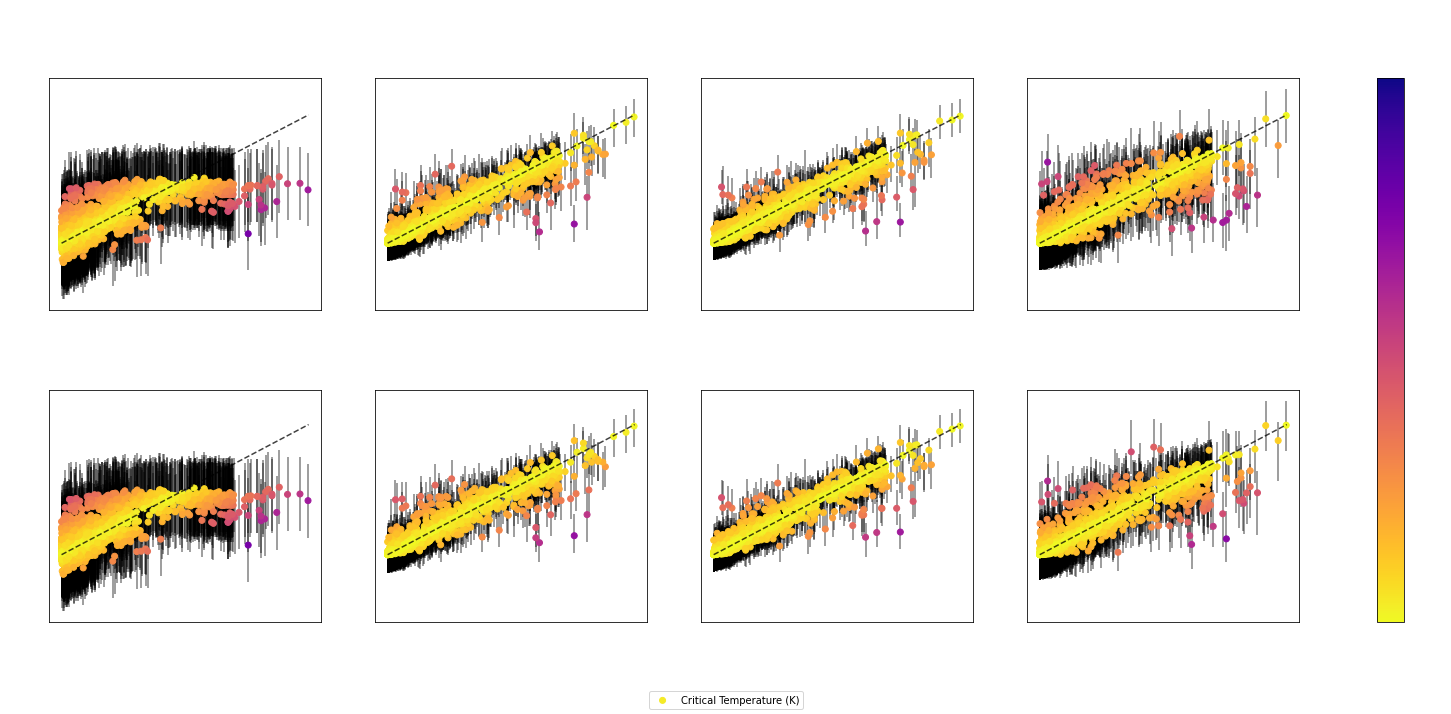

In [7]:
sfn.import_data(replace_inf=True)
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - All Data", filename="results_optimized.png", image=False, forestci=False, method="plus")

Starting training on Unoptimized Linear Regression
('Unoptimized Linear Regression', 314.889, 13.167, 92.332, 0.607, 76.8)
Starting training on Linear Regression
('Linear Regression', 314.889, 13.167, 92.332, 0.607, 76.8)
Starting training on Unoptimized Random Forest Regression
('Unoptimized Random Forest Regression', 73.654, 4.376, 72.549, 0.908, 38.976)
Starting training on Random Forest Regression
('Random Forest Regression', 73.979, 4.356, 72.351, 0.908, 39.13)
Starting training on Unoptimized Extra Trees Regression
('Unoptimized Extra Trees Regression', 61.268, 3.866, 79.471, 0.924, 36.61)
Starting training on Extra Trees Regression
('Extra Trees Regression', 61.5, 3.855, 75.612, 0.923, 36.401)
Starting training on Unoptimized KNeighbors Regression
('Unoptimized KNeighbors Regression', 158.505, 6.918, 81.02, 0.802, 59.042)
Starting training on KNeighbors Regression
('KNeighbors Regression', 126.932, 6.016, 77.5, 0.842, 53.481)


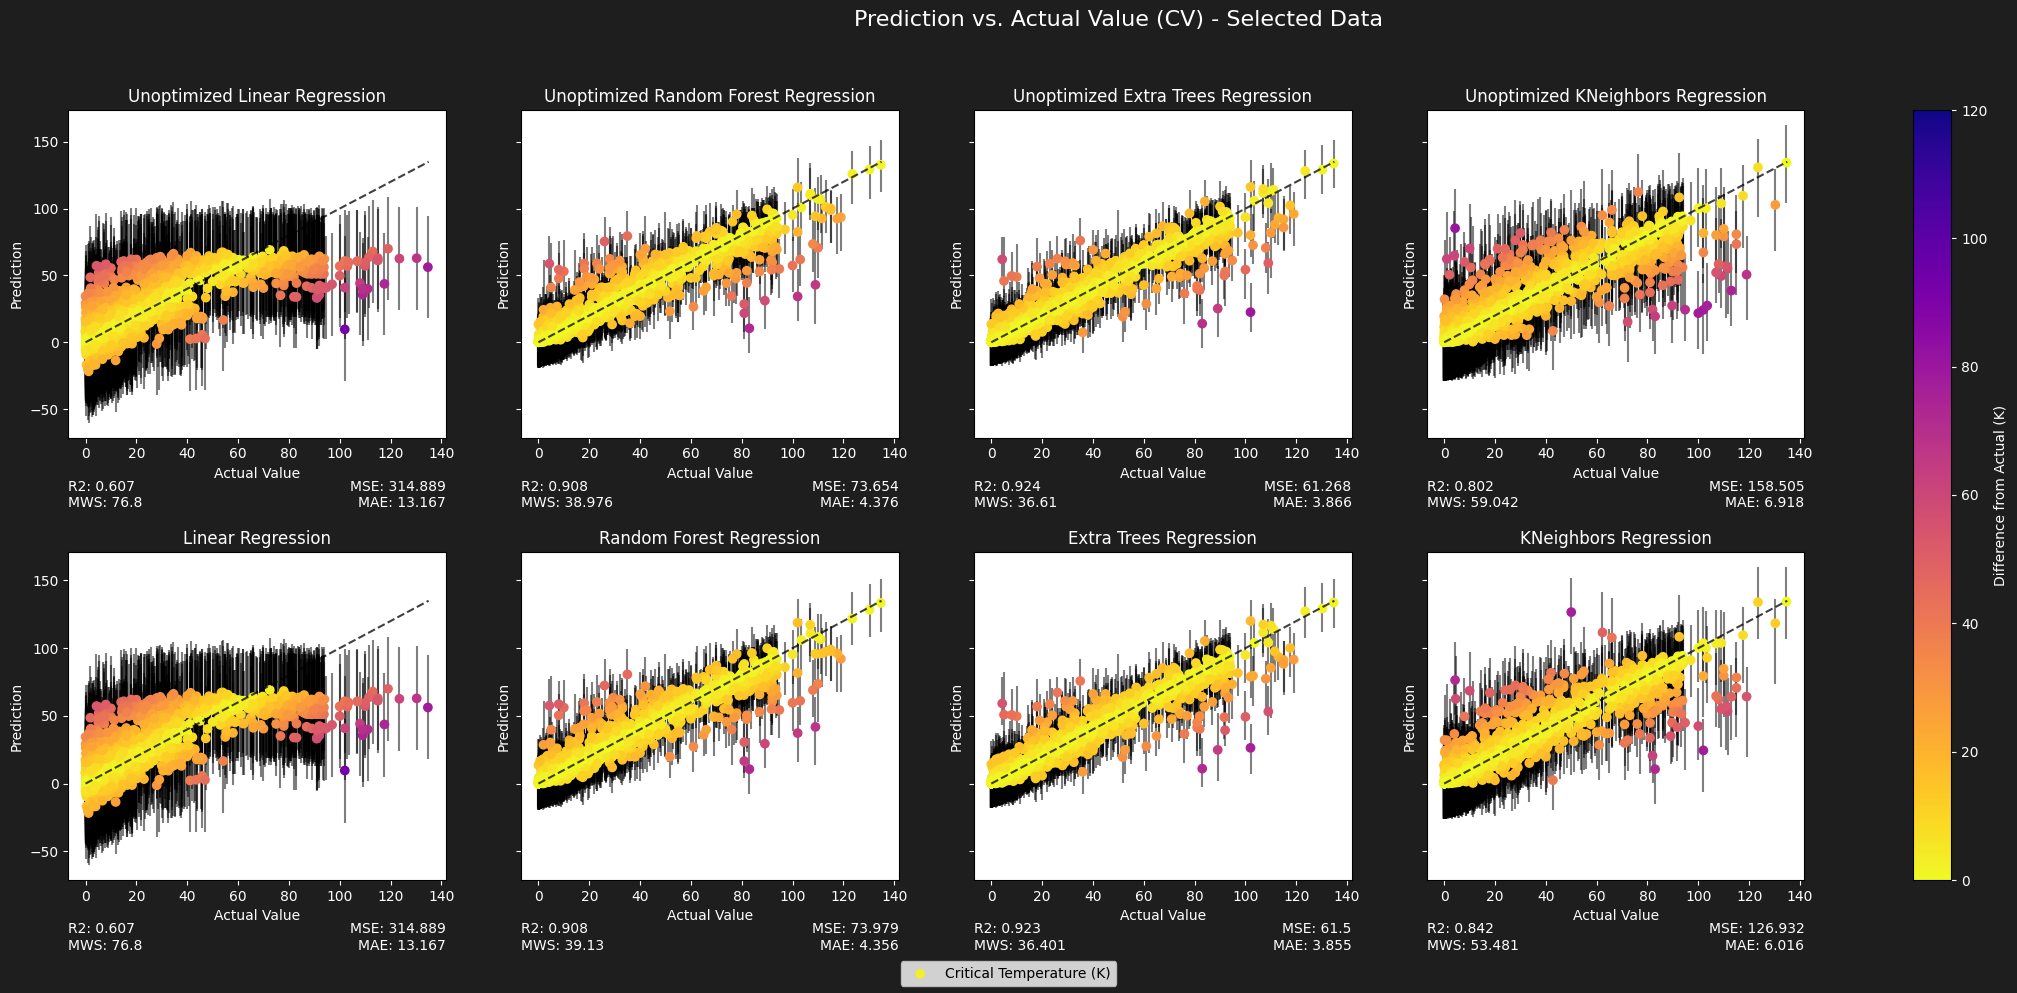

In [8]:
sfn.import_data(replace_inf=True, drop=poor_corr)
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Selected Data", filename="results_optimized.png", image=False, forestci=False, method="plus")

## Feature Importance

In [9]:
sfn.import_data(replace_inf=True) #reimport data without infinities

sfn.evaluate_one("Decision Tree", DecisionTreeRegressor, {}, uncertainty=False, image=False, feature_importance=True, show=False)
sfn.evaluate_one("Random Forest", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 300}, uncertainty=False, image=False, feature_importance=True, show=False)
sfn.evaluate_one("Extra Trees", ExtraTreesRegressor, {'n_estimators': 589}, uncertainty=False, image=False, feature_importance=True, show=False)

Starting training on Decision Tree
('Decision Tree', 132.458, 5.473, 91.8, 0.835, None)
Starting training on Random Forest
('Random Forest', 71.352, 4.313, 82.024, 0.911, None)
Starting training on Extra Trees
('Extra Trees', 59.181, 3.785, 76.297, 0.926, None)


<Figure size 640x480 with 0 Axes>

In [4]:
dti = pd.read_csv('../data/importance/decision_tree_importance.csv').nlargest(10,'Importance') 
rfi = pd.read_csv('../data/importance/random_forest_importance.csv').nlargest(10,'Importance')
eti = pd.read_csv('../data/importance/extra_trees_importance.csv').nlargest(10,'Importance')

dtni = pd.read_csv('../data/importance/decision_tree_importance.csv').nsmallest(43,'Importance') 
rfni = pd.read_csv('../data/importance/random_forest_importance.csv').nsmallest(43,'Importance')
etni = pd.read_csv('../data/importance/extra_trees_importance.csv').nsmallest(43,'Importance')

In [20]:
print("Decision Tree Top Features:")
display(dti)
print(dti.Feature.to_list())
print("\n\nRandom Forest Top Features:")
display(rfi)
print(rfi.Feature.to_list())
print("\n\nExtra Trees Top Features:")
display(eti)
print(eti.Feature.to_list())

Decision Tree Top Features:


,Feature,Importance
0,mean abs simul. packing efficiency,0.497477
1,MagpieData mean NUnfilled,0.082853
2,frac d valence electrons,0.066113
3,0-norm,0.047997
4,2-norm,0.022724
5,dist from 1 clusters |APE| < 0.010,0.020739
6,MagpieData mean NpUnfilled,0.020652
7,MagpieData mean GSvolume_pa,0.020336
8,MagpieData mean CovalentRadius,0.017930
9,MagpieData mean NdUnfilled,0.016527


['mean abs simul. packing efficiency', 'MagpieData mean NUnfilled', 'frac d valence electrons', '0-norm', '2-norm', 'dist from 1 clusters |APE| < 0.010', 'MagpieData mean NpUnfilled', 'MagpieData mean GSvolume_pa', 'MagpieData mean CovalentRadius', 'MagpieData mean NdUnfilled']


Random Forest Top Features:


,Feature,Importance
0,mean abs simul. packing efficiency,0.499029
1,MagpieData mean NUnfilled,0.081399
2,frac d valence electrons,0.062064
3,0-norm,0.043232
4,2-norm,0.019006
5,MagpieData mean GSvolume_pa,0.018807
6,MagpieData mean NpUnfilled,0.018142
7,dist from 1 clusters |APE| < 0.010,0.014884
8,MagpieData mean MeltingT,0.014552
9,MagpieData mean CovalentRadius,0.014262


['mean abs simul. packing efficiency', 'MagpieData mean NUnfilled', 'frac d valence electrons', '0-norm', '2-norm', 'MagpieData mean GSvolume_pa', 'MagpieData mean NpUnfilled', 'dist from 1 clusters |APE| < 0.010', 'MagpieData mean MeltingT', 'MagpieData mean CovalentRadius']


Extra Trees Top Features:


,Feature,Importance
0,mean abs simul. packing efficiency,0.209780
1,MagpieData mean NUnfilled,0.084808
2,0-norm,0.056052
3,MagpieData mean SpaceGroupNumber,0.050655
4,MagpieData mean MeltingT,0.039183
5,frac p valence electrons,0.037284
6,MagpieData mean Electronegativity,0.035670
7,2-norm,0.027792
8,MagpieData mean NdUnfilled,0.022542
9,MagpieData mean CovalentRadius,0.020331


['mean abs simul. packing efficiency', 'MagpieData mean NUnfilled', '0-norm', 'MagpieData mean SpaceGroupNumber', 'MagpieData mean MeltingT', 'frac p valence electrons', 'MagpieData mean Electronegativity', '2-norm', 'MagpieData mean NdUnfilled', 'MagpieData mean CovalentRadius']


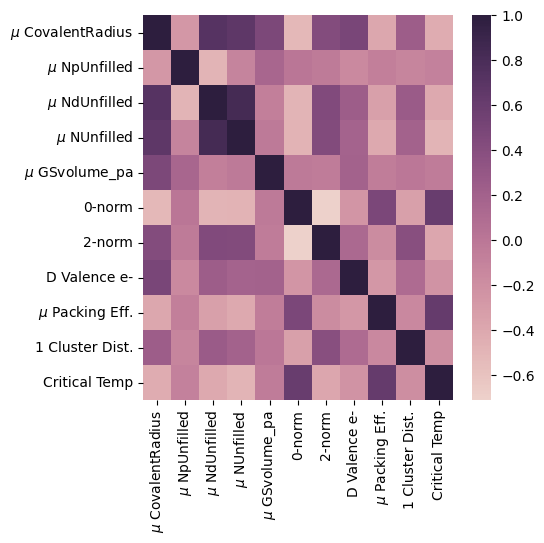

In [84]:
rename = {'MagpieData mean CovalentRadius':'$\mu$ CovalentRadius',
 'MagpieData mean NpUnfilled':'$\mu$ NpUnfilled',
 'MagpieData mean NdUnfilled':'$\mu$ NdUnfilled',
 'MagpieData mean NUnfilled':'$\mu$ NUnfilled',
 'MagpieData mean GSvolume_pa':'$\mu$ GSvolume_pa',
 '0-norm':'0-norm',
 '2-norm':'2-norm',
 'frac d valence electrons':'D Valence e-',
 'mean abs simul. packing efficiency':'$\mu$ Packing Eff.',
 'dist from 1 clusters |APE| < 0.010':'1 Cluster Dist.',
 'target':'Critical Temp'}

def analysis(): #makes a heatmap that shows correlations between features and targets, saves to '../data/feature_heatmap.png'
    global corr_matrix, graph_data
    sfn.import_data(replace_inf=True) #import data with function above

    graph_data = pd.DataFrame(sfn.data) #make a new dataframe for the correlation matrix
    graph_data.drop(dtni.Feature.to_list(), axis=1, inplace=True) #drop unimportant features
    graph_data['target'] = sfn.target.values #add target back in
    graph_data.rename(columns = rename, inplace = True) #rename columns

    corr_matrix = graph_data.corr() #gets 2D correlation matrix
    fig, ax = plt.subplots(figsize=(5, 5)) #define figure and sizing features
    ax = sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap=sns.cubehelix_palette(as_cmap=True))
    bottom, top = ax.get_ylim()
    # ax.tick_params(axis='y', rotation=25)
    # ax.tick_params(which='both') #set various colors
    # plt.tick_params(left=False, bottom=False)

    #save heatmap
    figure = ax.get_figure()    
    figure.savefig('../data/feature_heatmap_eti.png') #saves to '../data/feature_heatmap.png' at 480 dpi
    
analysis() #calls function

Starting training on Decision Tree - Selected Features
('Decision Tree - Selected Features', 144.284, 5.742, 98.0, 0.82, 60.984)


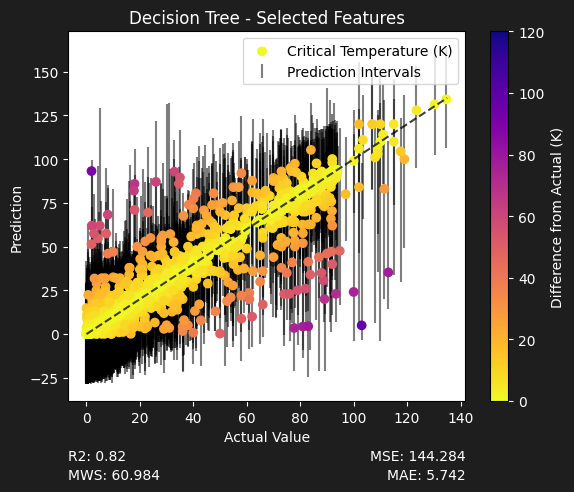

<Figure size 640x480 with 0 Axes>

In [10]:
sfn.import_data(replace_inf=True, drop=dtni.Feature.to_list())
sfn.evaluate_one("Decision Tree - Selected Features", DecisionTreeRegressor, {}, uncertainty=True, method="plus", image=True)

Starting training on Random Forest - Selected Features
('Random Forest - Selected Features', 87.403, 4.879, 73.165, 0.891, 42.998)


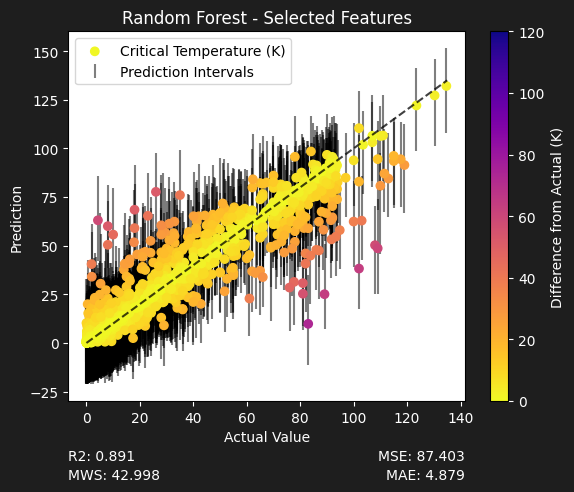

<Figure size 640x480 with 0 Axes>

In [11]:
sfn.import_data(replace_inf=True, drop=rfni.Feature.to_list())
sfn.evaluate_one("Random Forest - Selected Features", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 250}, uncertainty=True, method="plus", image=True)

Starting training on Extra Trees - Selected Features
('Extra Trees - Selected Features', 70.084, 4.094, 79.133, 0.913, 38.369)


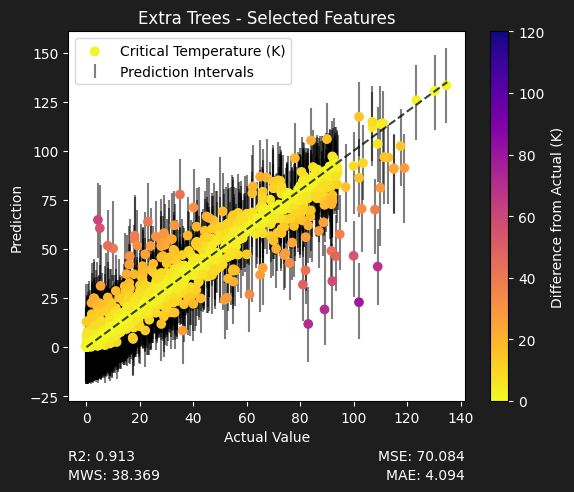

<Figure size 640x480 with 0 Axes>

In [12]:
sfn.import_data(replace_inf=True, drop=etni.Feature.to_list())
sfn.evaluate_one("Extra Trees - Selected Features", ExtraTreesRegressor, {'n_estimators': 589}, uncertainty=True, method="plus", image=True)

Starting training on Superlearner - Selected Features


/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/ana

('Superlearner - Selected Features', 70.71, 4.105, 80.855, 0.912, 38.602)


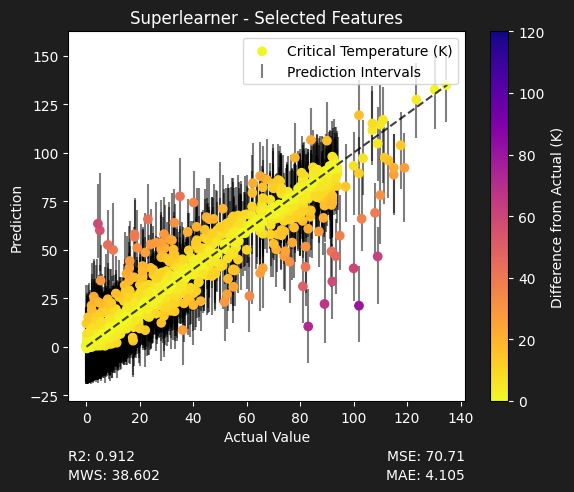

<Figure size 640x480 with 0 Axes>

In [13]:
sfn.import_data(replace_inf=True, drop=etni.Feature.to_list())
sfn.evaluate_one("Superlearner - Selected Features", Superlearner, {'X': sfn.train_data}, uncertainty=True, method="plus", image=True)